# Trabalho final: Raciocinio Espacial Neuro-Simbólico com LTNtorch
**Professor:** Edjard Mota

**Disciplina:** Fundamentos de Inteligência Artificial (ICC260)

**Alunos:**
* **André Kaled Duarte Coutinho Andrade** (andre.andrade@icomp.ufam.edu.br)
* **Conceição Barbosa Rocha** (conceicao.rocha@icomp.ufam.edu.br)
* **Julia Evelyn Chaparro Ferreira** (julia.ferreira@icomp.ufam.edu.br)
* **Luiz Henrique Barbosa Costa** (luiz.costa@icomp.ufam.edu.br)
* **Marcus Phablo Pereira de Oliveira** (marcus.oliveira@icomp.ufam.edu.br)
* **Paulo Victor Fernandes de Melo** (paulo.fernandes@icomp.ufam.edu.br)
* **Sven Maximilian Kalisch** (sven.kalisch@icomp.ufam.edu.br)
*
## Resumo do Projeto
Este projeto implementa um agente neuro-simbólico utilizando Logic Tensor Networks (LTN) para raciocinar sobre um ambiente simplificado. O objetivo é aprender e validar relações espaciais (esquerda, direita, acima, abaixo, entre) e atributos de objetos (forma, cor, tamanho) baseando-se em vetores de características, não em imagens brutas.

## Instalação e configuração inicial

In [1]:
import sys
!{sys.executable} -m pip uninstall -y ltn
!{sys.executable} -m pip install git+https://github.com/logictensornetworks/LTNtorch.git
!pip install torch matplotlib numpy

import torch
import ltn
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.path as mpath

torch.manual_seed(42)

  Cloning https://github.com/logictensornetworks/LTNtorch.git to /tmp/pip-req-build-423oe593
  Running command git clone --filter=blob:none --quiet https://github.com/logictensornetworks/LTNtorch.git /tmp/pip-req-build-423oe593
  Resolved https://github.com/logictensornetworks/LTNtorch.git to commit d1bd98169cc2121f8cdd25ff99901e4589923c95
  Preparing metadata (setup.py) ... done
  Created wheel for LTNtorch: filename=LTNtorch-1.0.2-py3-none-any.whl size=29525 sha256=41ee1c7b59b9b0c5977f5a2c86e6a1fcf3abdfa8a28c9b1de42470f74f107b53
  Stored in directory: /tmp/pip-ephem-wheel-cache-qpjfm6sd/wheels/27/7f/ad/18a09c0cb2a0fa9c3607e89d6baad1dd5ce62d029b050b0f99
Successfully built LTNtorch


# Tarefa 1: Taxonomia e Formas

## Geração de dados e plotagem


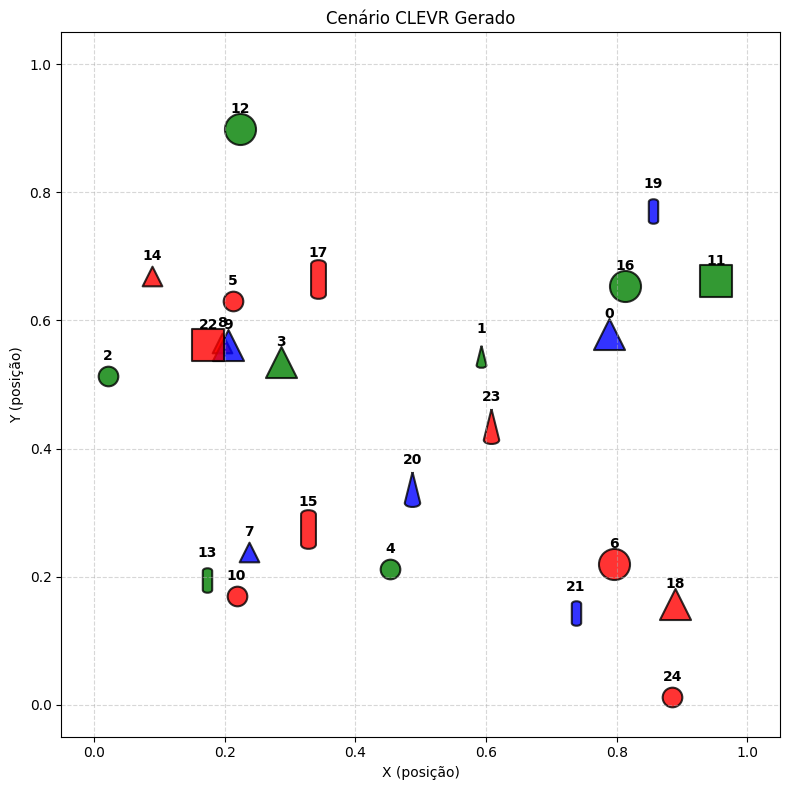

Dataset gerado. Shape: torch.Size([25, 11])
Exemplo: Large Blue Triangle
Vetor: tensor([0.7887, 0.5784, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 1.0000])


In [2]:
def get_custom_markers():
    """
    Cria caminhos (Paths) vetoriais para desenhar Cone e Cilindro
    com aparência 3D usando curvas de Bézier.
    """
    # Gemini que fez
    # --- CONE (Triângulo + Base Curva) ---
    verts_cone = [
        (0.0, 1.0),
        (-0.5, -1.0),
        (-0.5, -1.35),
        (0.5, -1.35),
        (0.5, -1.0),
        (0.0, 1.0)
    ]
    codes_cone = [
        mpath.Path.MOVETO,
        mpath.Path.LINETO,
        mpath.Path.CURVE4,
        mpath.Path.CURVE4,
        mpath.Path.CURVE4,
        mpath.Path.LINETO
    ]
    path_cone = mpath.Path(verts_cone, codes_cone)

    # --- CILINDRO (Retângulo + Topo/Base Curvos) ---
    verts_cyl = [
        (-0.5, 1.0),  # Topo Esq
        (-0.5, -1.0), # Baixo Esq
        (0.5, -1.0),  # Baixo Dir (Curva suave entre estes dois)
        (0.5, 1.0),   # Topo Dir
        (-0.5, 1.0),  # Volta Topo Esq (Curva suave entre estes dois)
        (-0.5, 0.95), # Um pequeno detalhe para fechar o "loop" visualmente
    ]
    codes_cyl = [
        mpath.Path.MOVETO,
        mpath.Path.LINETO,
        mpath.Path.CURVE4, # Controle 1 da base
        mpath.Path.CURVE4, # Controle 2 da base
        mpath.Path.CURVE4, # Fim da base
        mpath.Path.LINETO,
        mpath.Path.CURVE4, # Controle 1 do topo
        mpath.Path.CURVE4, # Controle 2 do topo
        mpath.Path.CURVE4  # Fim do topo
    ]

    verts_cyl_fixed = [
        (-0.5, 1.0),  # Start Top-Left
        (-0.5, -1.0), # Line to Bottom-Left

        # Curva de baixo (precisa de 2 pontos de controle + 1 final)
        (-0.5, -1.4), # Controle 1
        (0.5, -1.4),  # Controle 2
        (0.5, -1.0),  # Ponto Final (Bottom-Right)

        (0.5, 1.0),   # Line to Top-Right

        # Curva de cima (para fechar a tampa)
        (0.5, 1.4),   # Controle 1
        (-0.5, 1.4),  # Controle 2
        (-0.5, 1.0)   # Ponto Final (Top-Left)
    ]

    path_cyl = mpath.Path(verts_cyl_fixed, codes_cyl)

    return path_cone, path_cyl

def get_dataset_simplificado(n_exemplos=25):
    """
    Gera dataset CLEVR simplificado (x, y, cores, formas, tamanho).
    Vetor [11 features]:
    [0,1]: x, y
    [2,3,4]: r, g, b
    [5,6,7,8,9]: circle, square, cylinder, cone, triangle
    [10]: size (0=pequeno, 1=grande)
    """
    data = []
    labels = []

    nome_formas = ["Circle", "Square", "Cylinder", "Cone", "Triangle"]
    nome_cores = ["Red", "Green", "Blue"]
    nome_tamanhos  = ["Small", "Large"]

    for _ in range(n_exemplos):
        # posição
        x, y = np.random.rand(), np.random.rand()

        # cor (one-hot)
        cor_idx = np.random.randint(0, 3)
        cor_vet = [0.0]*3
        cor_vet[cor_idx] = 1.0

        # forma (one-hot)
        forma_idx = np.random.randint(0, 5)
        forma_vet = [0.0]*5
        forma_vet[forma_idx] = 1.0

        # tamanho
        grande = np.random.rand() > 0.5
        tamanho_val = 1.0 if grande else 0.0

        vet = [x, y] + cor_vet + forma_vet + [tamanho_val]
        data.append(vet)

        desc = f"{nome_tamanhos[int(tamanho_val)]} {nome_cores[cor_idx]} {nome_formas[forma_idx]}"
        labels.append(desc)

    return torch.tensor(data, dtype=torch.float32), labels

def plot_dataset_simplificado(data, labels, title="Cenário CLEVR Gerado"):
    plt.figure(figsize=(8, 8))
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.grid(True, linestyle='--', alpha=0.5)
    marcador_cone, marcador_cilindro = get_custom_markers()

    # 0: circle, 1: square, 2: cylinder, 3:cone, 4:triangle
    marcadores = ['o', 's', marcador_cilindro, marcador_cone, '^']

    # 0:Red, 1:Green, 2:Blue
    cores = ['red', 'green', 'blue']

    for i in range(len(data)):
        obj = data[i]
        x, y = obj[0].item(), obj[1].item()

        # Identificar cor (argmax dos indices 2,3,4)
        c_idx = torch.argmax(obj[2:5]).item()
        c = cores[c_idx]

        # Identificar forma (argmax dos indices 5,6,7,8,9)
        s_idx = torch.argmax(obj[5:10]).item()
        m = marcadores[s_idx]

        # tamanho (indice 10)
        size_val = obj[10].item()
        # grande: area=300, pequeno: area=100
        base_size = 500 if size_val > 0.5 else 200

        # cilindro ou cone
        if s_idx == 2 or s_idx == 3:
            base_size *= 1.8

        plt.scatter(x, y, c=c, marker=m, s=base_size, edgecolors='black', label=labels[i], alpha=0.8, linewidths=1.5)
        offset = 0.035 if s_idx in [2,3] else 0.025
        plt.text(x, y+offset, str(i), fontsize=10, ha='center', fontweight='bold', color='black')

    plt.title(title)
    plt.xlabel("X (posição)")
    plt.ylabel("Y (posição)")
    plt.tight_layout()
    plt.show()

# testando
data_batch, text_labels = get_dataset_simplificado(25)
plot_dataset_simplificado(data_batch, text_labels)
print(f"Dataset gerado. Shape: {data_batch.shape}")
print(f"Exemplo: {text_labels[0]}")
print(f"Vetor: {data_batch[0]}")

## Criando a rede LTN (com predicados)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
data, text = get_dataset_simplificado(50)

objetos = ltn.Variable("objects", data)

print(f"Dataset gerado com sucesso! Formato: {data.shape}")
print("Exemplo de um objeto (x, y, r, g, b, s):")
print(data[0])

Dataset gerado com sucesso! Formato: torch.Size([50, 11])
Exemplo de um objeto (x, y, r, g, b, s):
tensor([0.1696, 0.4586, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000])


In [5]:
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
SatAgg = ltn.fuzzy_ops.AggregMean()

class MLP(nn.Module):
    def __init__(self, layer_sizes=(11, 16, 16, 1)):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                layers.append(nn.ELU())
        self.main = nn.Sequential(*layers)

    def forward(self, x):
      x = x.to(self.main[0].weight.device)
      x = self.main(x)
      return torch.sigmoid(x)


#formas
is_circle = ltn.Predicate(MLP())
is_square = ltn.Predicate(MLP())
is_cylinder = ltn.Predicate(MLP())
is_cone = ltn.Predicate(MLP())
is_triangle = ltn.Predicate(MLP())

# cores
is_red = ltn.Predicate(MLP())
is_green = ltn.Predicate(MLP())
is_blue = ltn.Predicate(MLP())

# tamanhos
is_small = ltn.Predicate(MLP())
is_big = ltn.Predicate(MLP())

#juntando pra facilitar
formas_preds = [is_circle, is_square, is_cylinder, is_cone, is_triangle]
cores_preds = [is_red, is_green, is_blue]

### Importando modelo treinado

Execute apenas se tiver um modelo pronto!

In [6]:
checkpoint = torch.load("ltn_model.pt", map_location=device)

# Recrie os predicados exatamente como antes:
is_circle = ltn.Predicate(MLP().to(device))
is_square = ltn.Predicate(MLP().to(device))
is_cylinder = ltn.Predicate(MLP().to(device))
is_cone = ltn.Predicate(MLP().to(device))
is_triangle = ltn.Predicate(MLP().to(device))

is_red = ltn.Predicate(MLP().to(device))
is_green = ltn.Predicate(MLP().to(device))
is_blue = ltn.Predicate(MLP().to(device))

is_small = ltn.Predicate(MLP().to(device))
is_big = ltn.Predicate(MLP().to(device))

# Restaurar pesos
for name, pred in zip(["circle","square","cylinder","cone","triangle"], formas_preds):
    pred.model.load_state_dict(checkpoint["formas"][name])

for name, pred in zip(["red","green","blue"], cores_preds):
    pred.model.load_state_dict(checkpoint["cores"][name])

is_small.model.load_state_dict(checkpoint["tamanhos"]["small"])
is_big.model.load_state_dict(checkpoint["tamanhos"]["big"])

print("Modelo carregado!")


FileNotFoundError: [Errno 2] No such file or directory: 'ltn_model.pt'

## Definindo axiomas

In [7]:
def axiomas_logica(features_data):
    x = ltn.Variable("x", features_data.to(device))
    regras = []

    for i in range(len(formas_preds)):
        for j in range(i + 1, len(formas_preds)):
            f_i = formas_preds[i](x)
            f_j = formas_preds[j](x)
            regras.append(Forall(x, Not(And(f_i, f_j))))

    uma_forma = formas_preds[0](x)
    for i in range(1, len(formas_preds)):
        uma_forma = Or(uma_forma, formas_preds[i](x))
    regras.append(Forall(x, uma_forma))

    for i in range(len(cores_preds)):
        for j in range(i + 1, len(cores_preds)):
            regras.append(Forall(x, Not(And(cores_preds[i](x), cores_preds[j](x)))))

    regras.append(Forall(x, Not(And(is_small(x), is_big(x)))))
    regras.append(Forall(x, Or(is_small(x), is_big(x))))

    if len(regras) == 0:
        return torch.tensor(1.0, device=device)

    # empilhar os tensores das fórmulas e mover para device
    regra_tensors = [r.value.to(device) for r in regras]
    return SatAgg(torch.stack(regra_tensors))

def axiomas_supervisao(data, labels):
    regras_sup = []
    mapa_formas = {"Circle": is_circle, "Square": is_square, "Cylinder": is_cylinder, "Cone": is_cone, "Triangle": is_triangle}
    mapa_cores = {"Red": is_red, "Green": is_green, "Blue": is_blue}
    mapa_tamanhos = {"Small": is_small, "Large": is_big}

    for nome, predicado in mapa_formas.items():
        indices = [i for i, label in enumerate(labels) if nome in label]
        if len(indices) > 0:
            x_classe = ltn.Variable(f"x_{nome}", data[indices].to(device))
            regras_sup.append(Forall(x_classe, predicado(x_classe)))

    for nome, predicado in mapa_cores.items():
        indices = [i for i, label in enumerate(labels) if nome in label]
        if len(indices) > 0:
            x_classe = ltn.Variable(f"x_{nome}", data[indices].to(device))
            regras_sup.append(Forall(x_classe, predicado(x_classe)))

    for nome, predicado in mapa_tamanhos.items():
        indices = [i for i, label in enumerate(labels) if nome in label]
        if len(indices) > 0:
            x_classe = ltn.Variable(f"x_{nome}", data[indices].to(device))
            regras_sup.append(Forall(x_classe, predicado(x_classe)))

    if len(regras_sup) == 0:
        return torch.tensor(1.0, device=device)

    regra_tensors = [r.value.to(device) for r in regras_sup]
    return SatAgg(torch.stack(regra_tensors))

## Treinamento

Iniciando Treinamento (Lógica + Supervisão)...
Epoch 0 | Sat Final: 0.6318 (Logica: 0.7586, Sup: 0.5050)
Epoch 100 | Sat Final: 0.9774 (Logica: 0.9550, Sup: 0.9999)
Epoch 200 | Sat Final: 0.9775 (Logica: 0.9552, Sup: 0.9998)
Epoch 300 | Sat Final: 0.9998 (Logica: 0.9998, Sup: 0.9999)
Epoch 400 | Sat Final: 0.9999 (Logica: 0.9998, Sup: 0.9999)
Epoch 500 | Sat Final: 0.9999 (Logica: 0.9998, Sup: 0.9999)
Epoch 600 | Sat Final: 0.9999 (Logica: 0.9998, Sup: 0.9999)
Epoch 700 | Sat Final: 0.9999 (Logica: 0.9998, Sup: 0.9999)
Epoch 800 | Sat Final: 0.9999 (Logica: 0.9998, Sup: 0.9999)
Epoch 900 | Sat Final: 0.9999 (Logica: 0.9998, Sup: 0.9999)


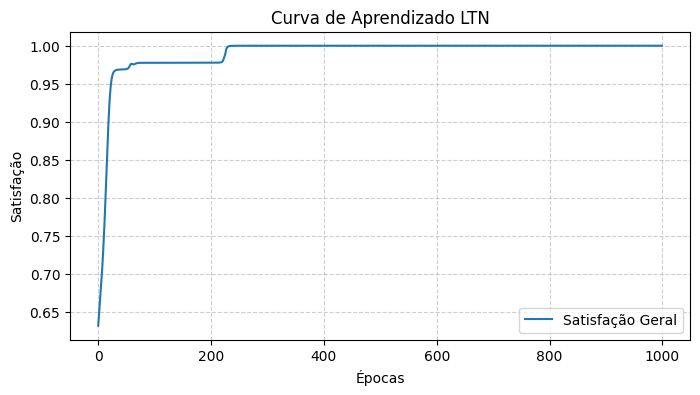

Treinamento Concluído!


In [8]:
all_preds = formas_preds + cores_preds + [is_small, is_big]
for p in all_preds:
    p.model.to(device)

# Coletamos parâmetros de todos os predicados para o otimizador
dados_treino, labels_treino = get_dataset_simplificado(n_exemplos=500)
dados_treino = dados_treino.to(device)

params = []
for p in all_preds:
    params += list(p.model.parameters())
optimizer = torch.optim.Adam(params, lr=0.01)

EPOCHS = 1000

print("Iniciando Treinamento (Lógica + Supervisão)...")
historico_loss = []


for epoch in range(EPOCHS):
    optimizer.zero_grad()

    # satisfação logica (regras internas)
    sat_logica = axiomas_logica(dados_treino)

    # satisfação supervisionada (aprender com Labels)
    sat_supervisao = axiomas_supervisao(dados_treino, labels_treino)

    # a rede deve obedecer a lógica e acertar os nomes
    sat_final = SatAgg(torch.stack([sat_logica, sat_supervisao]))

    # queremos minimizar o erro
    loss = 1.0 - sat_final

    loss.backward()
    optimizer.step()

    historico_loss.append(sat_final.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Sat Final: {sat_final.item():.4f} (Logica: {sat_logica.item():.4f}, Sup: {sat_supervisao.item():.4f})")

plt.figure(figsize=(8,4))
plt.plot(historico_loss, label="Satisfação Geral")
plt.xlabel("Épocas")
plt.ylabel("Satisfação")
plt.title("Curva de Aprendizado LTN")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("Treinamento Concluído!")

### Exportando modelo


In [9]:
checkpoint = {
    "formas": {name: pred.model.state_dict()
               for name, pred in zip(
                   ["circle","square","cylinder","cone","triangle"],
                   formas_preds
               )},
    "cores": {name: pred.model.state_dict()
              for name, pred in zip(
                  ["red","green","blue"],
                  cores_preds
              )},
    "tamanhos": {
        "small": is_small.model.state_dict(),
        "big": is_big.model.state_dict()
    }
}

torch.save(checkpoint, "ltn_model.pt")
print("Modelo salvo em ltn_model.pt")


Modelo salvo em ltn_model.pt


# Tarefa 2: Raciocínio Espacial

## Predicados

In [36]:
class RelacaoEspacial(nn.Module):
    def __init__(self, mode):
        super(RelacaoEspacial, self).__init__()
        self.mode = mode
        self.sigma = 15.0

    def forward(self, *inputs):
        if len(inputs) == 1 and isinstance(inputs[0], (list, tuple)):
            obj_a, obj_b = inputs[0][0], inputs[0][1]
        else:
            obj_a, obj_b = inputs[0], inputs[1]

        # Garante que não temos dimensões extras (ex: [1, 1, 11] -> [1, 11])
        if obj_a.ndim > 2:
            obj_a = obj_a.squeeze(1)
        if obj_b.ndim > 2:
            obj_b = obj_b.squeeze(1)

        if obj_a.shape[-1] < 2:
            # Se ainda estiver errado, retorna 0 silenciosamente ou avisa
            return torch.zeros((obj_a.shape[0], 1), device=obj_a.device)

        xa, ya = obj_a[:, 0], obj_a[:, 1]
        xb, yb = obj_b[:, 0], obj_b[:, 1]

        if self.mode == "left":
            return torch.sigmoid(self.sigma * (xb - xa))
        elif self.mode == "right":
            return torch.sigmoid(self.sigma * (xa - xb))
        elif self.mode == "below":
            return torch.sigmoid(self.sigma * (yb - ya))
        elif self.mode == "above":
            return torch.sigmoid(self.sigma * (ya - yb))
        elif self.mode == "close":
            eucl_sq = (xa - xb)**2 + (ya - yb)**2
            return torch.exp(-2.0 * eucl_sq * (self.sigma/2))

        return torch.zeros_like(xa)

# Recriando os predicados com a classe
LeftOf = ltn.Predicate(RelacaoEspacial("left"))
RightOf = ltn.Predicate(RelacaoEspacial("right"))
Below = ltn.Predicate(RelacaoEspacial("below"))
Above = ltn.Predicate(RelacaoEspacial("above"))
CloseTo = ltn.Predicate(RelacaoEspacial("close"))

## Axiomas

In [31]:
def bloco_axiomas_fundamentais(data):
    """
    Verifica as propriedades lógicas básicas:
    Irreflexividade, Assimetria, Inverso e Transitividade.
    """
    x = ltn.Variable("x", data)
    y = ltn.Variable("y", data)
    z = ltn.Variable("z", data)

    regras = []

    # Irreflexividade: x não pode estar à esquerda de si mesmo
    regras.append(Forall(x, Not(LeftOf(x, x))))

    # Assimetria: Se x < y, então y não pode ser < x
    regras.append(Forall([x, y],
        Implies(LeftOf(x, y), Not(LeftOf(y, x)))
    ))

    # Inverso: Esquerda <-> Direita (Se x < y então y > x)
    regras.append(Forall([x, y],
        ltn.Connective(ltn.fuzzy_ops.Equiv())(LeftOf(x, y), RightOf(y, x))
    ))

    # Transitividade: Se x < y E y < z, então x < z
    regras.append(Forall([x, y, z],
        Implies(And(LeftOf(x, y), LeftOf(y, z)), LeftOf(x, z))
    ))

    # Retorna a satisfação agregada dessas regras
    tensors = [r.value for r in regras]
    return SatAgg(torch.stack(tensors))

## Definindo Raciocinio horizontal

In [32]:
def InBetween(x, y, z):
    """
    Define se x está entre y e z.
    Lógica: (y < x < z) OU (z < x < y)
    """
    return Or(
        And(LeftOf(y, x), RightOf(z, x)),
        And(LeftOf(z, x), RightOf(y, x))
    )

def bloco_raciocinio_horizontal(data):
    x = ltn.Variable("x", data)
    y = ltn.Variable("y", data)
    z = ltn.Variable("z", data)

    consultas = {}

    # LastOnTheLeft: Existe um x que está à esquerda de todos os outros?
    # Nota: Not(CloseTo) para evitar comparar x com ele mesmo
    consultas['LastLeft'] = Exists(x,
        Forall(y,
            Implies(Not(CloseTo(x, y)), LeftOf(x, y))
        )
    )

    # LastOnTheRight: Existe um x que está à direita de todos?
    # Nota: Not(CloseTo) para evitar comparar x com ele mesmo
    consultas['LastRight'] = Exists(x,
        Forall(y,
            Implies(Not(CloseTo(x, y)), RightOf(x, y))
        )
    )

    # InBetween: Existe algum trio válido (x entre y e z)?
    consultas['ExistsBetween'] = Exists([x, y, z], InBetween(x, y, z))

    # LeftOfAllSquares: "Existe objeto à Esquerda de todos os Quadrados"
    # Fórmula: ∃x(∀y(IsSquare(y) => LeftOf(x, y)))
    # Nota: Se não houver quadrados no cenário, essa regra é verdadeira para qualquer x.
    consultas['LeftOfAllSquares'] = Exists(x,
        Forall(y,
            Implies(is_square(y), LeftOf(x, y))
        )
    )

    # SquareRightOfCircle: "Todo Quadrado está à Direita de todo Círculo"
    # Fórmula: ∀x,y ((IsSquare(x) ^ IsCircle(y)) => RightOf(x, y))
    consultas['SquareRightOfCircle'] = Forall([x, y],
        Implies(
            And(is_square(x), is_circle(y)),
            RightOf(x, y)
        )
    )

    # Retorna o dicionário com os resultados individuais
    return {k: v.value.item() for k, v in consultas.items()}

## Definindo Raciocínio vertical

In [33]:
def CanStack(x, y):
    """
    Define se o objeto x pode ser empilhado sobre y.
    Regra: x deve estar ACIMA de y (Above)
           E a base y NÃO pode ser instável (não Cone e não Triângulo).
    """
    base_instavel = Or(is_cone(y), is_triangle(y))
    # Para empilhar: x está acima de y E a base y é estável
    return And(Above(x, y), Not(base_instavel))

def bloco_raciocinio_vertical(data):
    """
    Avalia as regras e consultas do Raciocínio Vertical (Tarefa 3).
    """
    x = ltn.Variable("x", data)
    y = ltn.Variable("y", data)
    z = ltn.Variable("z", data)

    consultas = {}

    # Inverso: Abaixo <-> Acima
    # Se x está abaixo de y, então y está acima de x (e vice-versa)
    # equivalência lógica (A <-> B)
    # (Below -> Above) AND (Above -> Below)
    consultas['VerticalInverse'] = Forall([x, y],
        And(
            Implies(Below(x, y), Above(y, x)),
            Implies(Above(y, x), Below(x, y))
        )
    )

    # Transitividade: Se x está abaixo de y E y está abaixo de z -> x está abaixo de z
    consultas['VerticalTransitivity'] = Forall([x, y, z],
        Implies(
            And(Below(x, y), Below(y, z)),
            Below(x, z)
        )
    )

    # CanStack: Existe algum par (x, y) onde o empilhamento é válido?
    consultas['ExistsStackable'] = Exists([x, y], CanStack(x, y))

    # Retorna o dicionário com os valores de satisfação (.value.item())
    return {k: v.value.item() for k, v in consultas.items()}

## Tarefa 4: Raciocínio Composto

In [58]:
def bloco_raciocinio_composto(data):
    """
    Avalia as consultas complexas da Tarefa 4.
    """
    x = ltn.Variable("x", data)
    y = ltn.Variable("y", data)
    z = ltn.Variable("z", data)

    consultas = {}

    # --- 4.1. Filtragem Composta ---
    # CORREÇÃO: Adicionado o prefixo 'T' para bater com o script final
    consultas['T4.1_ComplexFilter'] = Exists(x,
        And(
            is_small(x),
            And(
                Exists(y, And(is_cylinder(y), Below(x, y))),
                Exists(z, And(is_square(z), LeftOf(x, z)))
            )
        )
    ).value.item()

    # --- 4.2. Dedução de Posição Absoluta ---
    # CORREÇÃO: Adicionado o prefixo 'T'
    consultas['T4.2_GreenConeBetween'] = Exists([x, y, z],
        And(
            And(is_cone(x), is_green(x)),
            InBetween(x, y, z)
        )
    ).value.item()

    # --- 4.3. Restrição de Proximidade (Nova Regra) ---
    # CORREÇÃO: Adicionado o prefixo 'T'
    same_size = Or(
        And(is_small(x), is_small(y)),
        And(is_big(x), is_big(y))
    )

    consultas['T4.3_TriProximity'] = Forall([x, y],
        Implies(
            And(is_triangle(x), And(is_triangle(y), CloseTo(x, y))),
            same_size
        )
    ).value.item()

    return consultas

## Entregas (Relatório)

==================== GERANDO RELATÓRIO FINAL (5 RODADAS) ====================


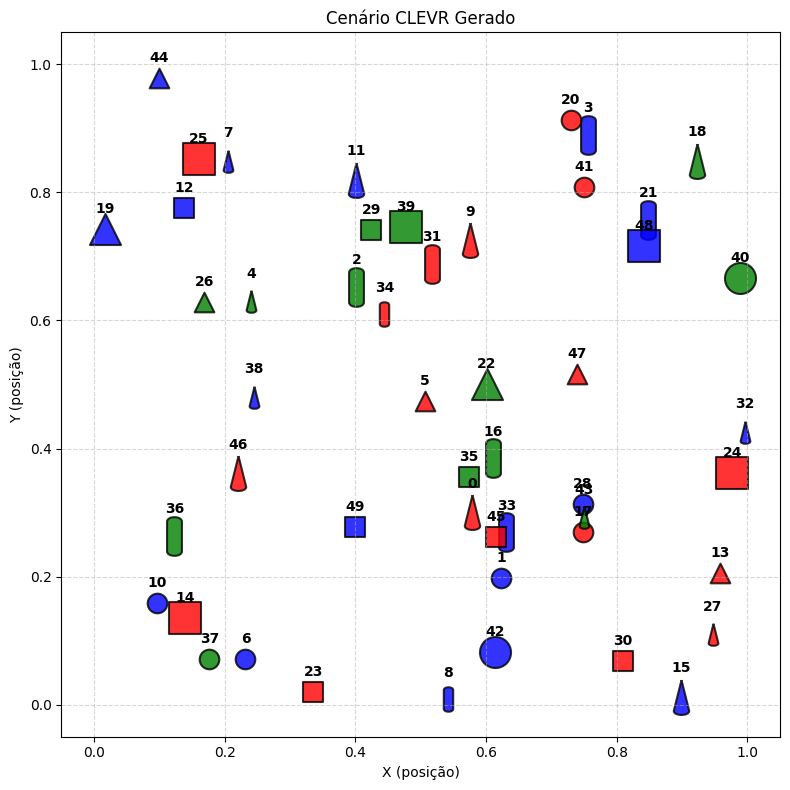

Execução 1: Acc=1.00 | F1=1.00 | Sat_Stack=0.54


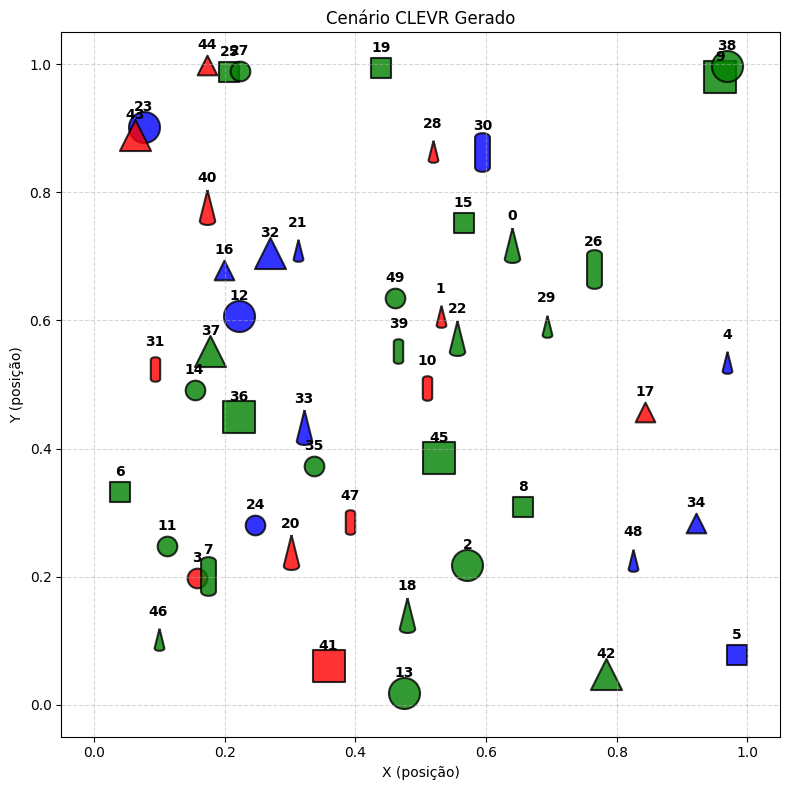

Execução 2: Acc=1.00 | F1=1.00 | Sat_Stack=0.51


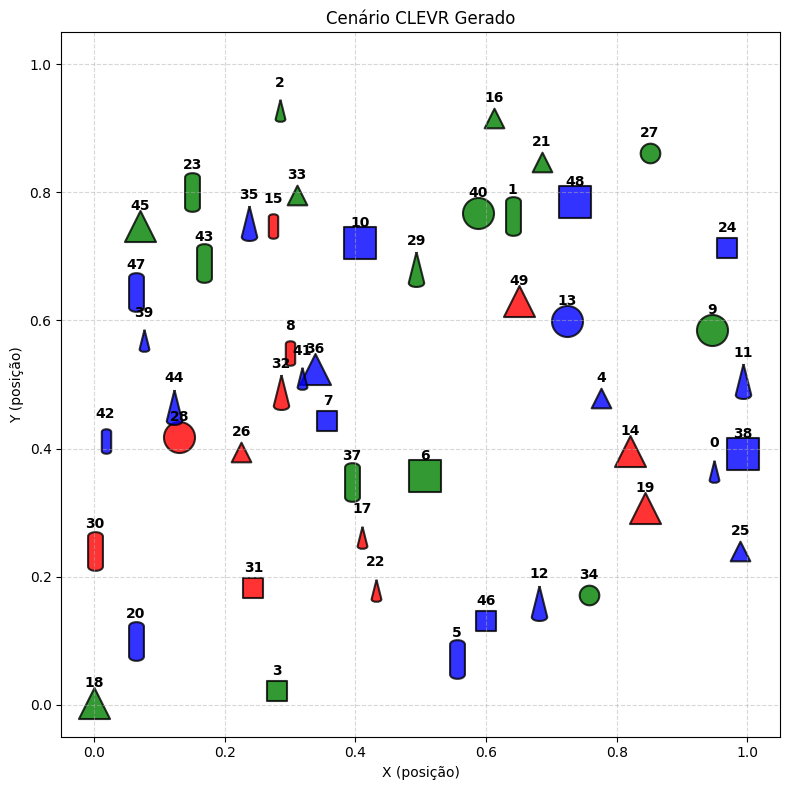

Execução 3: Acc=1.00 | F1=1.00 | Sat_Stack=0.48


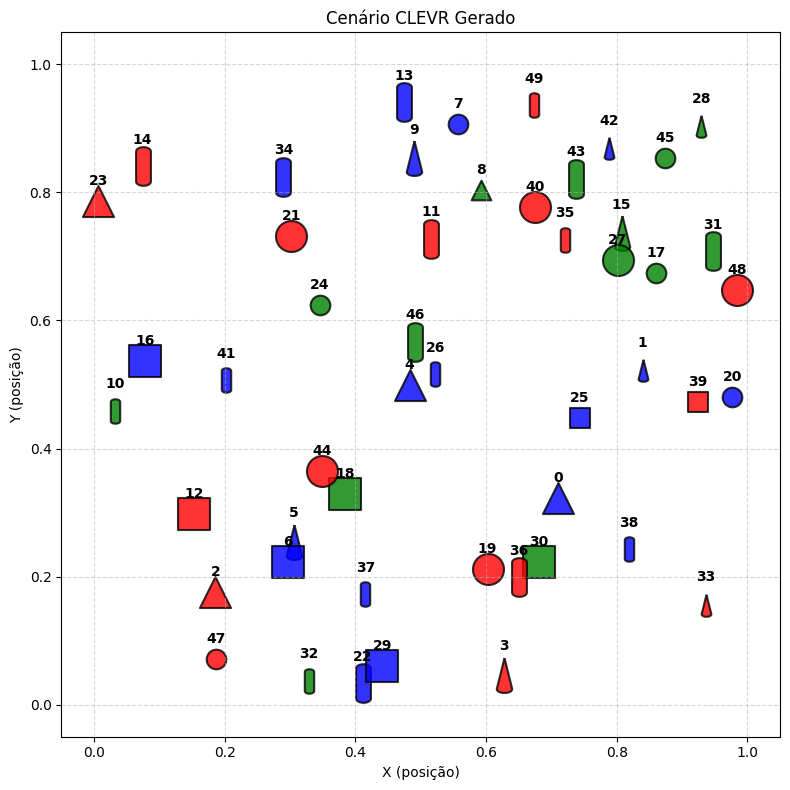

Execução 4: Acc=1.00 | F1=1.00 | Sat_Stack=0.57


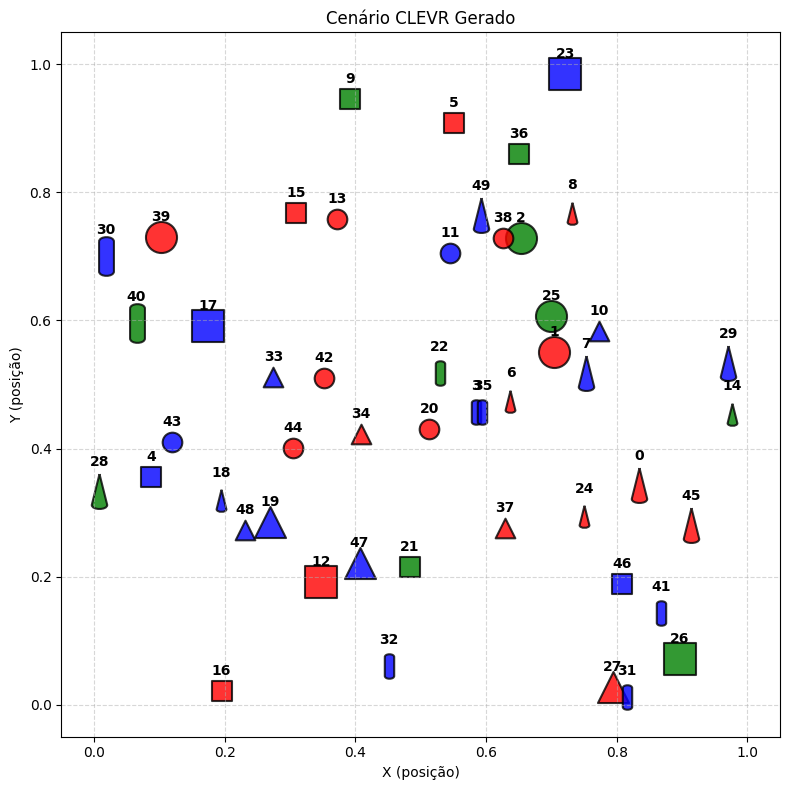

Execução 5: Acc=1.00 | F1=1.00 | Sat_Stack=0.49

TABELA FINAL DE RESULTADOS (MÉDIAS)


,Execução,Acurácia,Precision,Recall,F1-Score,Sat_LastLeft,Sat_InBetween,Sat_Inv_Vert,Sat_CanStack,Sat_ComplexFilter,Sat_GreenCone,Sat_TriProximity
0,1,1.0000,1.0000,1.0000,1.0000,0.5192,0.4824,0.8082,0.5388,0.0703,0.1092,0.9620
1,2,1.0000,1.0000,1.0000,1.0000,0.5391,0.4772,0.8146,0.5117,0.0576,0.1595,0.9575
2,3,1.0000,1.0000,1.0000,1.0000,0.5333,0.4871,0.8024,0.4788,0.0637,0.1184,0.9498
3,4,1.0000,1.0000,1.0000,1.0000,0.5190,0.4826,0.8066,0.5727,0.0582,0.0770,0.9941
4,5,1.0000,1.0000,1.0000,1.0000,0.5355,0.4809,0.8030,0.4939,0.0582,0.0324,0.9554
5,MÉDIA,1.0000,1.0000,1.0000,1.0000,0.5292,0.4820,0.8070,0.5192,0.0616,0.0993,0.9638


In [61]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

def calcular_metricas_classificacao(data, labels):
    """
    Compara a predição da rede com os labels reais para calcular Acurácia, F1, etc.
    """
    map_shapes = ["Circle", "Square", "Cylinder", "Cone", "Triangle"]
    map_colors = ["Red", "Green", "Blue"]
    map_sizes  = ["Small", "Large"]

    y_true_s, y_true_c, y_true_sz = [], [], []

    for l in labels:
        for i, s in enumerate(map_shapes):
            if s in l: y_true_s.append(i); break
        for i, c in enumerate(map_colors):
            if c in l: y_true_c.append(i); break
        for i, sz in enumerate(map_sizes):
            if sz in l: y_true_sz.append(i); break

    # Predições (O que a rede acha)
    # Formas
    logits_s = torch.cat([p.model(data) for p in formas_preds], dim=1)
    y_pred_s = torch.argmax(logits_s, dim=1).cpu().detach().numpy()

    # Cores
    logits_c = torch.cat([p.model(data) for p in cores_preds], dim=1)
    y_pred_c = torch.argmax(logits_c, dim=1).cpu().detach().numpy()

    # Tamanho
    logits_sz = torch.cat([is_small.model(data), is_big.model(data)], dim=1)
    y_pred_sz = torch.argmax(logits_sz, dim=1).cpu().detach().numpy()

    # 3. Calcular Médias
    acc = (accuracy_score(y_true_s, y_pred_s) +
           accuracy_score(y_true_c, y_pred_c) +
           accuracy_score(y_true_sz, y_pred_sz)) / 3.0

    f1 = (f1_score(y_true_s, y_pred_s, average='macro', zero_division=0) +
          f1_score(y_true_c, y_pred_c, average='macro', zero_division=0) +
          f1_score(y_true_sz, y_pred_sz, average='macro', zero_division=0)) / 3.0

    prec = (precision_score(y_true_s, y_pred_s, average='macro', zero_division=0) +
            precision_score(y_true_c, y_pred_c, average='macro', zero_division=0) +
            precision_score(y_true_sz, y_pred_sz, average='macro', zero_division=0)) / 3.0

    rec = (recall_score(y_true_s, y_pred_s, average='macro', zero_division=0) +
           recall_score(y_true_c, y_pred_c, average='macro', zero_division=0) +
           recall_score(y_true_sz, y_pred_sz, average='macro', zero_division=0)) / 3.0

    return acc, prec, rec, f1

# --- LOOP DE GERAÇÃO DA TABELA ---

print(f"{'='*20} GERANDO RELATÓRIO FINAL (5 RODADAS) {'='*20}")
resultados = []

for i in range(5):
    # 1. Dados Frescos
    data, labels = get_dataset_simplificado(n_exemplos=50)
    data = data.to(device)
    plot_dataset_simplificado(data, labels)

    # 2. Métricas de Classificação (Tarefa 1)
    acc, prec, rec, f1 = calcular_metricas_classificacao(data, labels)

    # 3. Satisfação Lógica (Tarefas 2, 3 e 4)
    # Chamando as funções que criamos
    res_horiz = bloco_raciocinio_horizontal(data)
    res_vert = bloco_raciocinio_vertical(data)
    res_comp = bloco_raciocinio_composto(data) # Tarefa 4

    # Organizar linha para o DataFrame
    linha = {
        "Execução": i + 1,
        # Métricas ML
        "Acurácia": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        # Tarefa 2 (Horizontal)
        "Sat_LastLeft": res_horiz['LastLeft'],
        "Sat_InBetween": res_horiz['ExistsBetween'],
        # Tarefa 3 (Vertical)
        "Sat_Inv_Vert": res_vert['VerticalInverse'],
        "Sat_CanStack": res_vert['ExistsStackable'],
        # Tarefa 4 (Composto)
        "Sat_ComplexFilter": res_comp['T4.1_ComplexFilter'],
        "Sat_GreenCone": res_comp['T4.2_GreenConeBetween'],
        "Sat_TriProximity": res_comp['T4.3_TriProximity']
    }
    resultados.append(linha)
    print(f"Execução {i+1}: Acc={acc:.2f} | F1={f1:.2f} | Sat_Stack={res_vert['ExistsStackable']:.2f}")

df_final = pd.DataFrame(resultados)

media = df_final.mean(numeric_only=True)
df_media = pd.DataFrame([media])
df_media["Execução"] = "MÉDIA"

# Concatenar
df_final = pd.concat([df_final, df_media], ignore_index=True)

cols = ["Execução"] + [c for c in df_final.columns if c != "Execução"]
df_final = df_final[cols]

print("\n" + "="*60)
print("TABELA FINAL DE RESULTADOS (MÉDIAS)")
print("="*60)
pd.set_option('display.float_format', '{:.4f}'.format)
display(df_final)